**Global Settings**

In [ ]:
# Name of the directory on Google Drive for saving training log, loss/mAP chart,
# and weights
SAVE_DIR = 'yolov4_crowdhuman'

# Path of the Google Drive mount point
DRIVE_DIR = '/content/drive/My Drive'

# Full path to the save directory on Google Drive
DRIVE_SAVE_DIR = DRIVE_DIR + '/' + SAVE_DIR

# Input shape {width}*{height} of the yolov4 model to be trained
INPUT_SHAPE = '416x416'

Check and make sure Google Drive has been mounted before proceeding.

In [ ]:
from pathlib import Path
assert Path(DRIVE_DIR).is_dir(), 'Google Drive has not been mounted?'

**GPU Runtime**

Let's do a quick check which GPU has been allocated.

According to [Google Colab FAQ](https://research.google.com/colaboratory/faq.html#gpu-availability), "the GPUs available in Colab often include Nvidia K80s, T4s, P4s and P100s."  You should look for the "Name" field in nvidia-smi output below to see which GPU is used for this session.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Wed Sep 13 05:27:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Step-by-step**

The training process has been broken down into small steps below.  This way, you could easily check and fix an issue when it occurs.  And here's a word of caution before you start:  **Do not run this same (unmodified) notebook on 2 or more browser sessions simultaneously.**  Since the training processes would write training log and mAP/loss chart to the same files on your Google Drive, the results would be very confusing if you do that...

**Step 1**

Clone "yolov4_crowdhuman" source code from GitHub.

In [ ]:
%cd /content
if not Path('yolov4_crowdhuman').is_dir():
    !git clone https://github.com/jkjung-avt/yolov4_crowdhuman.git

/content


**Step 2**

Run the "prepare_data.sh" script in the "data/" subdirectory.  The script would download CrowdHuman dataset and unzip all train/val image files.  In addition, it also converts CrowdHuman annotations into YOLO txt files.

This step could take up to 20~30 minutes.  (TODO: Consider to delete the zip files in /content/yolov4_crowdhuman/data/raw to save storage space on the Colab runtime?)

In [ ]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
%cd /content/yolov4_crowdhuman/data
!./prepare_data.sh {INPUT_SHAPE}

Streaming output truncated to the last 5000 lines.
Processing ID: 282555,19ec300061bfd9e9
Processing ID: 273278,3dde4000263464b7
Processing ID: 282555,1200670007d50295b
Processing ID: 284193,1cc57000009322d5
Processing ID: 273278,c6eda0007fb9380f
Processing ID: 282555,33ff100035776f08
Processing ID: 273275,921ab0003e5e0914
Processing ID: 273275,6aeaa0005bd1ebea
Processing ID: 282555,1215c0000c2b2adb2
Processing ID: 282555,bbf810006c43fac8
Processing ID: 273278,b5d16000011d18a1
Processing ID: 273278,76f8900018333c49
Processing ID: 282555,12714000968539fa
Processing ID: 283647,241d00004ecfc04
Processing ID: 283554,3cc1100077b38ce8
Processing ID: 273278,13ff51000fa0db26a
Processing ID: 284193,25cd8000f3200193
Processing ID: 273278,d1624000c82ca0e7
Processing ID: 273278,13b0ba0009329d1c9
Processing ID: 283992,2f8f000e7134e70
Processing ID: 283081,40300051c350e8
Processing ID: 273278,2ecda000634a8974
Processing ID: 284193,21c5b000266bd1ad
Processing ID: 273278,1114e000001abbfa1
Processing I

**Step 3**

Check out "darknet" source code from GitHub.

In [ ]:
%cd /content/yolov4_crowdhuman
!rm -rf darknet
!git clone https://github.com/AlexeyAB/darknet.git

/content/yolov4_crowdhuman
Cloning into 'darknet'...
remote: Enumerating objects: 15750, done.
remote: Counting objects: 100% (213/213), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 15750 (delta 104), reused 162 (delta 92), pack-reused 15537
Receiving objects: 100% (15750/15750), 14.65 MiB | 22.23 MiB/s, done.
Resolving deltas: 100% (10533/10533), done.


**Step 4**

Patch darknet source code and build executable.  Note the following CUDA arch settings in the patch:

* "37": Tesla K80
* "60": Tesla P100
* "61": Tesla P4
* "75": Tesla T4

In [ ]:
%cd /content/yolov4_crowdhuman/darknet
!sed -i "1s/GPU=0/GPU=1/"               Makefile
!sed -i "2s/CUDNN=0/CUDNN=1/"           Makefile
!sed -i "3s/CUDNN_HALF=0/CUDNN_HALF=1/" Makefile
!sed -i "4s/OPENCV=0/OPENCV=1/"         Makefile
!sed -i "5s/AVX=0/AVX=1/"               Makefile
!sed -i "7s/LIBSO=0/LIBSO=1/"           Makefile
!sed -i "20s/compute_30,code=sm_30 \\\/compute_37,code=sm_37 -gencode arch=compute_60,code=[sm_60,compute_60] -gencode arch=compute_61,code=[sm_61,compute_61] -gencode arch=compute_75,code=[sm_75,compute_75]/" Makefile
!sed -i "21s/^/#/"                      Makefile
!sed -i "22s/^/#/"                      Makefile
!sed -i "23s/^/#/"                      Makefile
!sed -i "24s/^/#/"                      Makefile
# Let darknet test mAP more frequently during training
!sed -i "300s/calc_map_for_each = 4/calc_map_for_each = 1/" src/detector.c

!make

/content/yolov4_crowdhuman/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -ffp-contract=fast -mavx -mavx2 -msse3 -msse4.1 -msse4.2 -msse4a -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image

**Step 5**

Create folders and symlinks for saving training log and results.

In [ ]:
!mkdir -p "{DRIVE_SAVE_DIR}"
!rm -f "{DRIVE_SAVE_DIR}"/train.log
!touch "{DRIVE_SAVE_DIR}"/chart.png
!rm -f chart.png
!ln -sf "{DRIVE_SAVE_DIR}"/chart.png .
!mkdir -p "{DRIVE_SAVE_DIR}"/backup
!rm -rf backup
!ln -sf "{DRIVE_SAVE_DIR}"/backup .

**Step 6**

Set up all remaining files needed for training the model.  The pre-trained yolov4 weights file ("yolov4.conv.137") is also downloaded here.

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
%cd /content/yolov4_crowdhuman
!./prepare_training.sh {INPUT_SHAPE}

/content/yolov4_crowdhuman
** Install requirements
** Copy files for training
** Download pre-trained yolov4 weights
Downloading...
From: https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
To: /content/yolov4_crowdhuman/darknet/yolov4.conv.137
100% 170M/170M [00:02<00:00, 73.9MB/s]
** Done.


**Step 7**

Start training!  The total number of training iterations is 5,000.

Training progress could be checked by looking at the following files on your Google Drive:

   ```
   yolov4_crowdhuman/train.log
   yolov4_crowdhuman/chart.png
   ```

In [ ]:
%cd /content/yolov4_crowdhuman/darknet
!./darknet detector train data/crowdhuman-{INPUT_SHAPE}.data cfg/yolov4-crowdhuman-{INPUT_SHAPE}.cfg yolov4.conv.137 -gpus 0 -map -dont_show 2>&1 | tee "{DRIVE_SAVE_DIR}"/train.log | grep -E "hours left|mean_average"

Streaming output truncated to the last 5000 lines.
 1502: 36.010403, 25.645943 avg loss, 0.001000 rate, 4.880940 seconds, 36048 images, 2.266612 hours left
 (next mAP calculation at 2500 iterations) 1503/4000: loss=27.8 hours left=2.3
 1503: 27.846247, 25.865973 avg loss, 0.001000 rate, 4.399063 seconds, 36072 images, 2.277814 hours left
 (next mAP calculation at 2500 iterations) 1504/4000: loss=40.5 hours left=2.3
 1504: 40.479900, 27.327366 avg loss, 0.001000 rate, 4.679038 seconds, 36096 images, 2.285549 hours left
 (next mAP calculation at 2500 iterations) 1505/4000: loss=32.2 hours left=2.3
 1505: 32.179043, 27.812534 avg loss, 0.001000 rate, 4.281614 seconds, 36120 images, 2.295135 hours left
 (next mAP calculation at 2500 iterations) 1506/4000: loss=23.8 hours left=2.3
 1506: 23.817780, 27.413059 avg loss, 0.001000 rate, 4.082676 seconds, 36144 images, 2.301859 hours left
 (next mAP calculation at 2500 iterations) 1507/4000: loss=27.2 hours left=2.3
 1507: 27.212557, 27.393

**Step 8**

The trained "yolov4-crowdhuman-416x416" model (weights) is saved in the "yolov4_crowdhuman/backup/" directory on your Google Drive.

Let's test the "best" trained model.

In [ ]:
import re

def count_person_head():
    """
    Count the occurrences of 'person' and 'head' in the Darknet output file.

    Prints the counts for each class ('person' and 'head').
    Assumes the Darknet output file is located at a constant path.

    Returns:
    None
    """
    file_path = '/content/drive/MyDrive/output.txt'
    confidence_threshold = 50  # Minimum confidence threshold for counting

    # Read the Darknet output file
    with open(file_path, 'r') as f:
        darknet_output = f.read()

    # Define a dictionary to store counts for each class
    class_counts = {'person': 0, 'head': 0}

    # Parse the output and count occurrences of 'person' and 'head'
    lines = darknet_output.split('\n')
    for line in lines:
        match = re.match(r'(\w+): (\d+)%', line)
        if match:
            class_name, confidence = match.groups()
            confidence = int(confidence)
            if class_name in class_counts and confidence >= confidence_threshold:
                class_counts[class_name] += 1

    # Print the counts for each class
    for class_name, count in class_counts.items():
        print(f'Number of {class_name}s: {count}')



In [ ]:
%pwd

'/content/yolov4_crowdhuman'

In [ ]:
!./darknet/darknet detector test /content/drive/MyDrive/yolov4_crowdhuman/data/crowdhuman-416x416.data /content/drive/MyDrive/yolov4_crowdhuman/data/yolov4-crowdhuman-416x416.cfg /content/drive/MyDrive/yolov4_crowdhuman/backup/yolov4-crowdhuman-416x416_best.weights /content/drive/MyDrive/yolov4_crowdhuman/antarafoto-aturan-baru-penumpang-krl-090322-adm-10_ratio-16x9.jpg -gpus 0 -dont_show > /content/drive/MyDrive/output.txt
count_person_head()
# from IPython.display import Image
# Image('/content/yolov4_crowdhuman/darknet/predictions.jpg')

 CUDA-version: 11080 (12000), cuDNN: 8.9.0, CUDNN_HALF=1, GPU count: 1  
 OpenCV version: 4.5.4
Cannot load image data/labels/32_0.png
Cannot load image data/labels/33_0.png
Cannot load image data/labels/34_0.png
Cannot load image data/labels/35_0.png
Cannot load image data/labels/36_0.png
Cannot load image data/labels/37_0.png
Cannot load image data/labels/38_0.png
Cannot load image data/labels/39_0.png
Cannot load image data/labels/40_0.png
Cannot load image data/labels/41_0.png
Cannot load image data/labels/42_0.png
Cannot load image data/labels/43_0.png
Cannot load image data/labels/44_0.png
Cannot load image data/labels/45_0.png
Cannot load image data/labels/46_0.png
Cannot load image data/labels/47_0.png
Cannot load image data/labels/48_0.png
Cannot load image data/labels/49_0.png
Cannot load image data/labels/50_0.png
Cannot load image data/labels/51_0.png
Cannot load image data/labels/52_0.png
Cannot load image data/labels/53_0.png
Cannot load image data/labels/54_0.png
Cannot 

**Step 9**

For reference, I got a "yolov4-crowdhuman-416x416" model with mAP ~0.77.  Here's the loss/mAP chart.

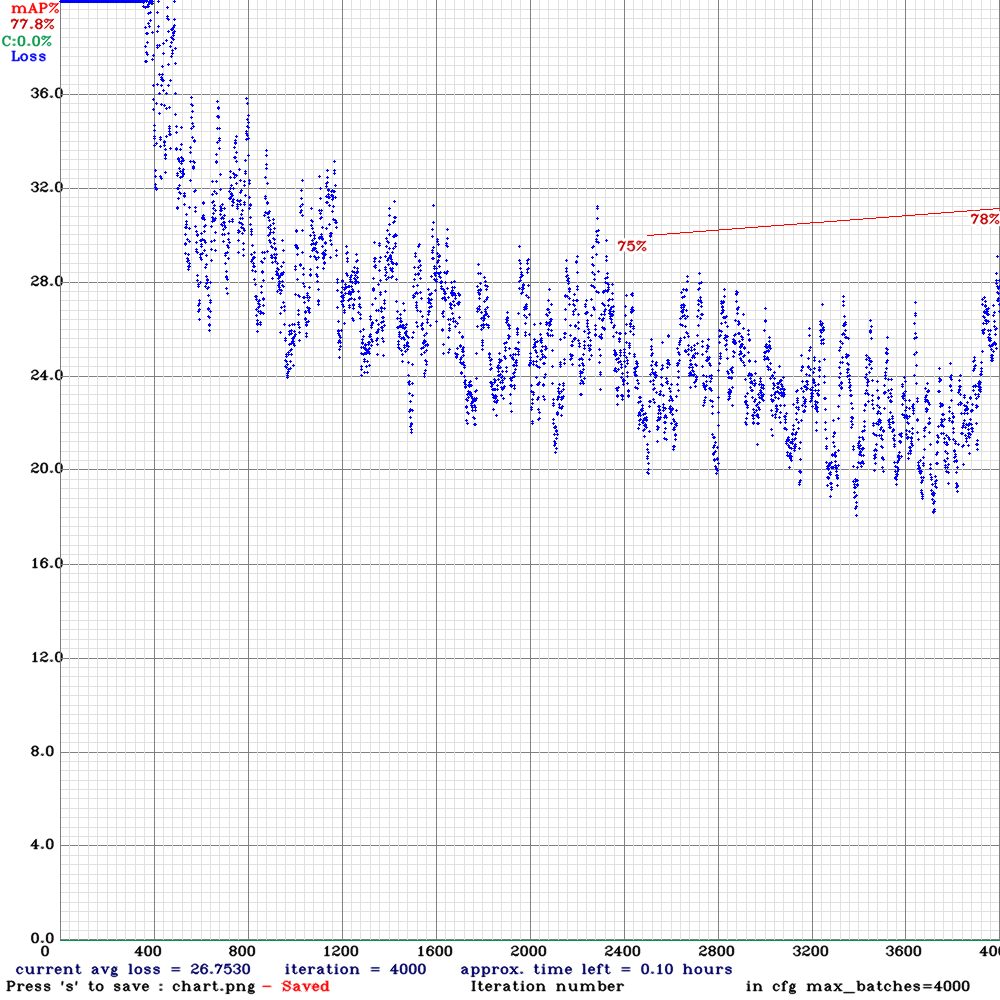

In [ ]:
Image('chart.png')

**All done.**

If possible, terminate the GPU session manually (for keeping a good record on Google Colab :-).

In [ ]:
# Define the file path
file_path = '/content/yolov4_crowdhuman/data/crowdhuman-416x416/train.txt'

# Open and read the file
with open(file_path, 'r') as file:
    content = file.read()

# Print the file content
print(content)


data/crowdhuman-416x416/284193,faa9000f2678b5e.jpg
data/crowdhuman-416x416/273275,cd061000af95f691.jpg
data/crowdhuman-416x416/273278,8d231000e09fc133.jpg
data/crowdhuman-416x416/283554,2cd4d0007833968d.jpg
data/crowdhuman-416x416/283554,37ba1000a6ca8c4d.jpg
data/crowdhuman-416x416/273278,c70ac000e431e2c7.jpg
data/crowdhuman-416x416/282555,55764000e90078a5.jpg
data/crowdhuman-416x416/273278,e1b7e000c8170e05.jpg
data/crowdhuman-416x416/273275,66624000c3de7f7d.jpg
data/crowdhuman-416x416/283554,35288000868e92d4.jpg
data/crowdhuman-416x416/273275,a6bc900004a5122b.jpg
data/crowdhuman-416x416/273278,8bfa200051531e1d.jpg
data/crowdhuman-416x416/273275,f73d8000feba4a38.jpg
data/crowdhuman-416x416/284193,2ecc4000a822149a.jpg
data/crowdhuman-416x416/273275,59b50000f22dfcf2.jpg
data/crowdhuman-416x416/282555,12298d000f1e45cda.jpg
data/crowdhuman-416x416/273278,cac480005a9d945f.jpg
data/crowdhuman-416x416/283554,b59f00076f3fdfd.jpg
data/crowdhuman-416x416/283554,1e6c0000fe110cec.jpg
data/crowdhum

In [ ]:
from google.colab import files

# Path to the file you want to download
file_path = '/content/yolov4_crowdhuman/data/crowdhuman-416x416/test.txt'

# Trigger the download
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>